In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from zoobot import label_metadata, schemas
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay
from scipy.optimize import linear_sum_assignment as linear_assignment
import time
import matplotlib.pyplot as plt

In [2]:
def findChoice(frac):
    choice = np.zeros_like(frac)
    choice[np.arange(len(frac)), frac.argmax(1)] = 1
    return choice

def getQuestionClasses(auto_f, volunteers, question):
    qcol_name = question.text+'_total-votes'
    fcol_names = [(cols.text+'_fraction') for cols in question.answers]
    anscol_names = [cols.text for cols in question.answers]
    valid_feats = []
    
    valid_vol = volunteers.query('`{}`/`smooth-or-featured_total-votes` >= 0.5'.format(qcol_name))
    valid_idx = valid_vol.index.tolist()
    vol_results = valid_vol[fcol_names].values
    
    auto_values = auto_f.values
    
    for i in valid_idx:
        valid_feats.append(auto_values[i])
        
    rounded_vol_results = findChoice(np.asarray(vol_results))
    support = len(rounded_vol_results)
    
    pred_results = KMeans(n_clusters=len(fcol_names), verbose=0).fit_predict(valid_feats)
    
    vol_classes = np.argmax(rounded_vol_results, axis=1)
    
    return valid_idx, support, anscol_names, np.array(pred_results), np.array(vol_classes)

In [3]:
def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

def labelMap(vol, pred):
    cm = confusion_matrix(vol, pred)
    indexes = linear_assignment(_make_cost_m(cm))
    indexes = np.asarray(indexes)
    return indexes[1]
    
def convertLabels(lmap, pred):
    conv_preds = []
    for i in range(len(pred)):
        conv_preds.append(lmap[pred[i]])
    return np.array(conv_preds)

In [4]:
auto_features = pd.read_csv("../autoencoder/extracted_features.csv")

In [5]:
auto_features = auto_features.drop('file_loc',axis=1)

In [6]:
decals_test = pd.read_csv('../Ilifu_data/decals_ilifu_test.csv')
schema = schemas.Schema(label_metadata.decals_pairs, label_metadata.get_gz2_and_decals_dependencies(label_metadata.decals_pairs))

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


In [7]:
idxs, support, anscols, valid_preds, valid_vol = getQuestionClasses(auto_features, decals_test, schema.get_question('edge-on-bulge'))

In [8]:
lmap = labelMap(valid_vol, valid_preds)
conv_pred = convertLabels(lmap, valid_preds)

In [9]:
cmOG = confusion_matrix(valid_vol, valid_preds)
cmNew = confusion_matrix(valid_vol, conv_pred)

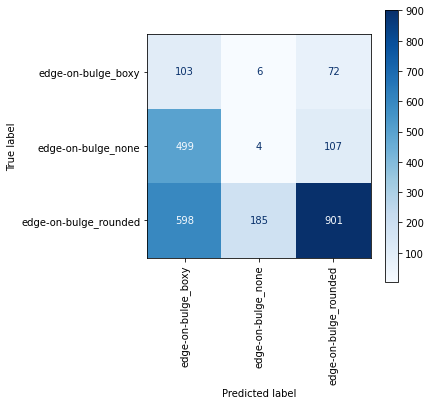

In [11]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ConfusionMatrixDisplay(cmOG, display_labels=anscols).plot(cmap='Blues', xticks_rotation='vertical', values_format='d', ax=ax)
plt.show()

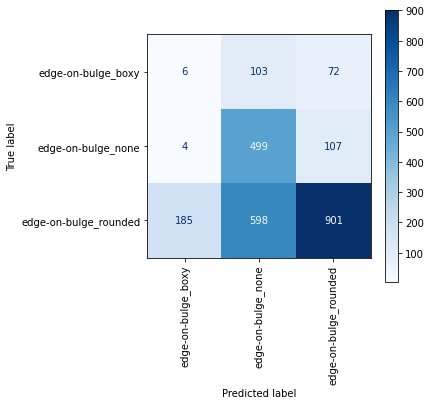

In [12]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ConfusionMatrixDisplay(cmNew, display_labels=anscols).plot(cmap='Blues', xticks_rotation='vertical', values_format='d', ax=ax)
plt.show()